In [54]:
import tensorflow as tf
import src.data.datasets as data
from sklearn.preprocessing import MinMaxScaler
import src.data.preprocessor as pre
import src.model.network as net 
import numpy as np
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras import backend as K
import os
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"]="-1"  

dataset = data.get_dataset("CMAPSS1")
window_size = 30
calib = 75
data_num = 100
alpha = 0.2

scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)

test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=window_size-1)
test = pre.dataframe_to_supervised(test, n_in=window_size-1)


X = np.vstack(train[0][:calib])
y = np.vstack(train[1][:calib])

X_calib = np.vstack(train[0][calib:])
y_calib = np.vstack(train[1][calib:])

X_test = []
y_test = []
for i in range(data_num):
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])

X_test = np.array(X_test)
y_test = np.array(y_test)
# model = net.create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0)
# model.summary()


# model.compile(optimizer=Adam(learning_rate=1e-1), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# model.fit(x=X, y=y, batch_size = 512, epochs = 50)


def quantile_loss(q,y_true,y_pred):
    """
    q -- quantile level
    y_true -- true values
    y_pred -- predicted values
    """
    diff = (y_true - y_pred)
    mask = y_true >= y_pred
    mask_ = y_true < y_pred
    loss = (q * K.sum(tf.boolean_mask(diff, mask), axis=-1) - (1 - q) * K.sum(tf.boolean_mask(diff, mask_), axis=-1))
    return loss

model_low = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_high = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_mean = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)

model_low.compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_high .compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(1-alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_mean.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

model_low.fit(x=X, y=y, batch_size = 512, epochs = 50)
model_high.fit(x=X, y=y, batch_size = 512, epochs = 50)
model_mean.fit(x=X, y=y, batch_size = 512, epochs = 50)



Epoch 1/50
26/26 [==============================] - 6s 183ms/step - loss: 3041.2468 - root_mean_squared_error: 65.7169
Epoch 2/50
26/26 [==============================] - 7s 266ms/step - loss: 2266.9404 - root_mean_squared_error: 47.9513
Epoch 3/50
26/26 [==============================] - 9s 327ms/step - loss: 2070.1729 - root_mean_squared_error: 43.0502
Epoch 4/50
26/26 [==============================] - 8s 327ms/step - loss: 1913.6084 - root_mean_squared_error: 40.5226
Epoch 5/50
26/26 [==============================] - 9s 328ms/step - loss: 1762.9392 - root_mean_squared_error: 36.2613
Epoch 6/50
26/26 [==============================] - 8s 319ms/step - loss: 1726.4988 - root_mean_squared_error: 34.7906
Epoch 7/50
26/26 [==============================] - 8s 321ms/step - loss: 1718.1295 - root_mean_squared_error: 34.9652
Epoch 8/50
26/26 [==============================] - 8s 300ms/step - loss: 1659.4087 - root_mean_squared_error: 33.4890
Epoch 9/50
26/26 [==============================

4/4 [==============================] - 0s 18ms/step


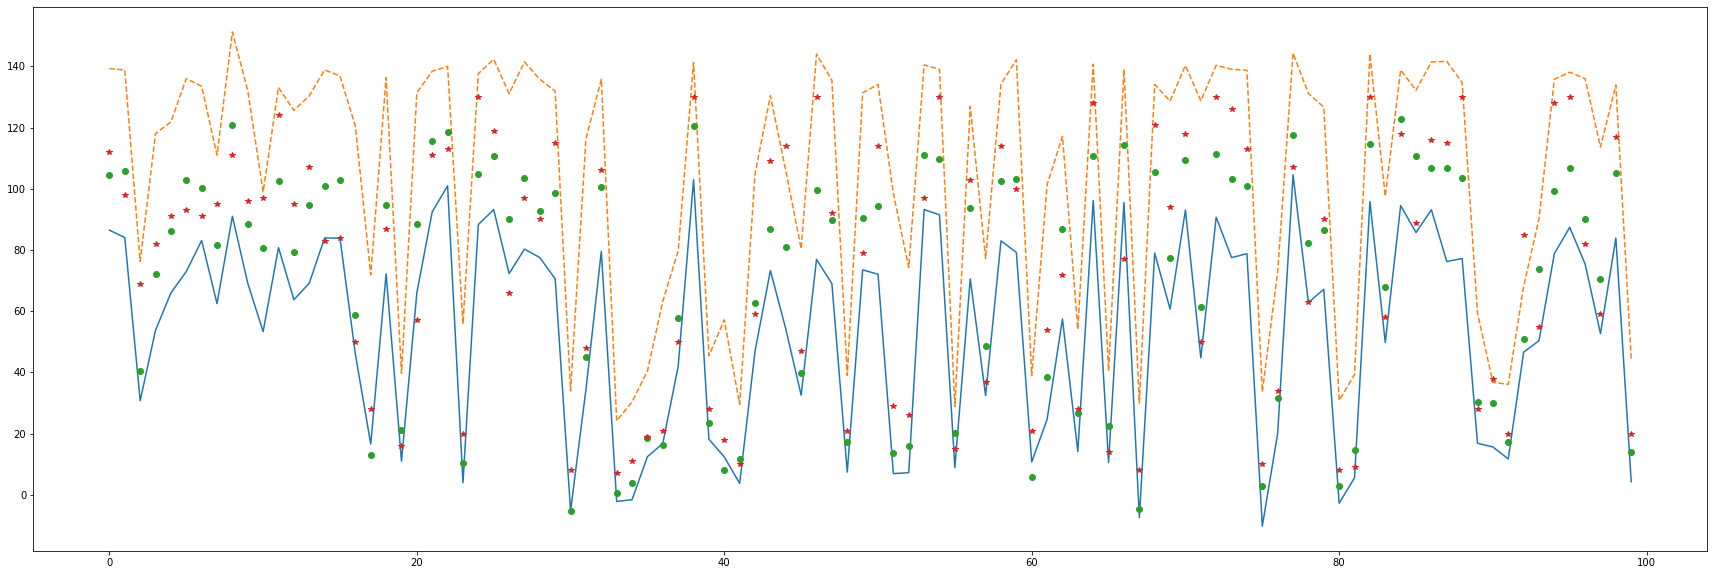

In [55]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test),'-')
plt.plot(model_high.predict(X_test),'--')
plt.plot(model_mean.predict(X_test),'o')
plt.plot(y_test, '*')

In [56]:
scores = np.maximum(model_low.predict(X_calib) - y_calib, y_calib - model_high.predict(X_calib))

149/149 [==============================] - 3s 19ms/step


In [57]:
n = calib
q = np.quantile(scores, np.ceil((n+1)*(1-alpha))/n)

In [58]:
q

-3.9649774169921885

4/4 [==============================] - 0s 18ms/step


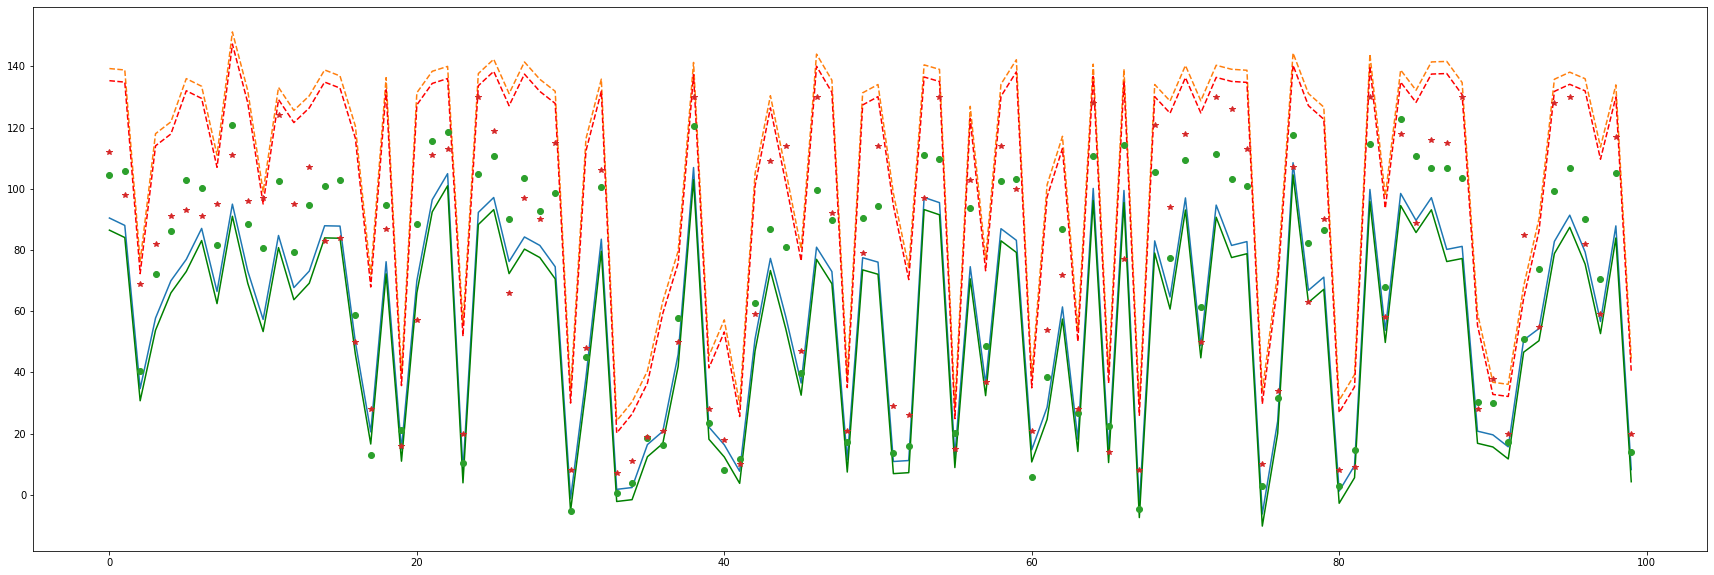

In [59]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test)-q,'-')
plt.plot(model_low.predict(X_test),'g-')
plt.plot(model_high.predict(X_test),'--')
plt.plot(model_high.predict(X_test)+q,'r--')
plt.plot(model_mean.predict(X_test),'o')
plt.plot(y_test, '*')

In [60]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test))

4/4 [==============================] - 0s 19ms/step


50.663467

In [61]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test) + 2*q)

4/4 [==============================] - 0s 19ms/step


42.733505

In [63]:
model_mean.evaluate(X_test, y_test)

4/4 [==============================] - 0s 11ms/step - loss: 214.8919 - root_mean_squared_error: 14.6592


[214.89190673828125, 14.659192085266113]

# train calib split

In [158]:
from sklearn.model_selection import train_test_split

dataset = data.get_dataset("CMAPSS1")
window_size = 30
calib_size = 0.1
alpha = 0.1
epochs = 50

scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)

test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=window_size-1)
test = pre.dataframe_to_supervised(test, n_in=window_size-1)


X = np.vstack(train[0])
y = np.vstack(train[1])

X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=calib_size, random_state=42)

X_test = []
y_test = []
for i in range(len(test[0])):
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])

X_test = np.array(X_test)
y_test = np.array(y_test)
# model = net.create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0)
# model.summary()


# model.compile(optimizer=Adam(learning_rate=1e-1), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# model.fit(x=X, y=y, batch_size = 512, epochs = 50)


def quantile_loss(q,y_true,y_pred):
    """
    q -- quantile level
    y_true -- true values
    y_pred -- predicted values
    """
    diff = (y_true - y_pred)
    mask = y_true >= y_pred
    mask_ = y_true < y_pred
    loss = (q * K.sum(tf.boolean_mask(diff, mask), axis=-1) - (1 - q) * K.sum(tf.boolean_mask(diff, mask_), axis=-1))
    return loss

model_low    = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_high   = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_median = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_mean   = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)

model_low.compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_high.compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(1-alpha/2,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_median.compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(0.5,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_mean.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

model_low.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
model_high.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
model_median.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)
model_mean.fit(x=X_train, y=y_train, batch_size = 512, epochs = epochs)

Epoch 1/50
32/32 [==============================] - 8s 162ms/step - loss: 1699.2218 - root_mean_squared_error: 76.0346
Epoch 2/50
32/32 [==============================] - 5s 163ms/step - loss: 1111.8256 - root_mean_squared_error: 47.0382
Epoch 3/50
32/32 [==============================] - 5s 160ms/step - loss: 1008.1067 - root_mean_squared_error: 42.1375
Epoch 4/50
32/32 [==============================] - 5s 165ms/step - loss: 952.1525 - root_mean_squared_error: 39.4606
Epoch 5/50
32/32 [==============================] - 5s 161ms/step - loss: 944.7350 - root_mean_squared_error: 39.0543
Epoch 6/50
32/32 [==============================] - 5s 157ms/step - loss: 914.3308 - root_mean_squared_error: 38.2891
Epoch 7/50
32/32 [==============================] - 5s 158ms/step - loss: 921.2712 - root_mean_squared_error: 38.2460
Epoch 8/50
32/32 [==============================] - 5s 156ms/step - loss: 923.4084 - root_mean_squared_error: 38.5740
Epoch 9/50
32/32 [==============================] - 5

4/4 [==============================] - 0s 10ms/step


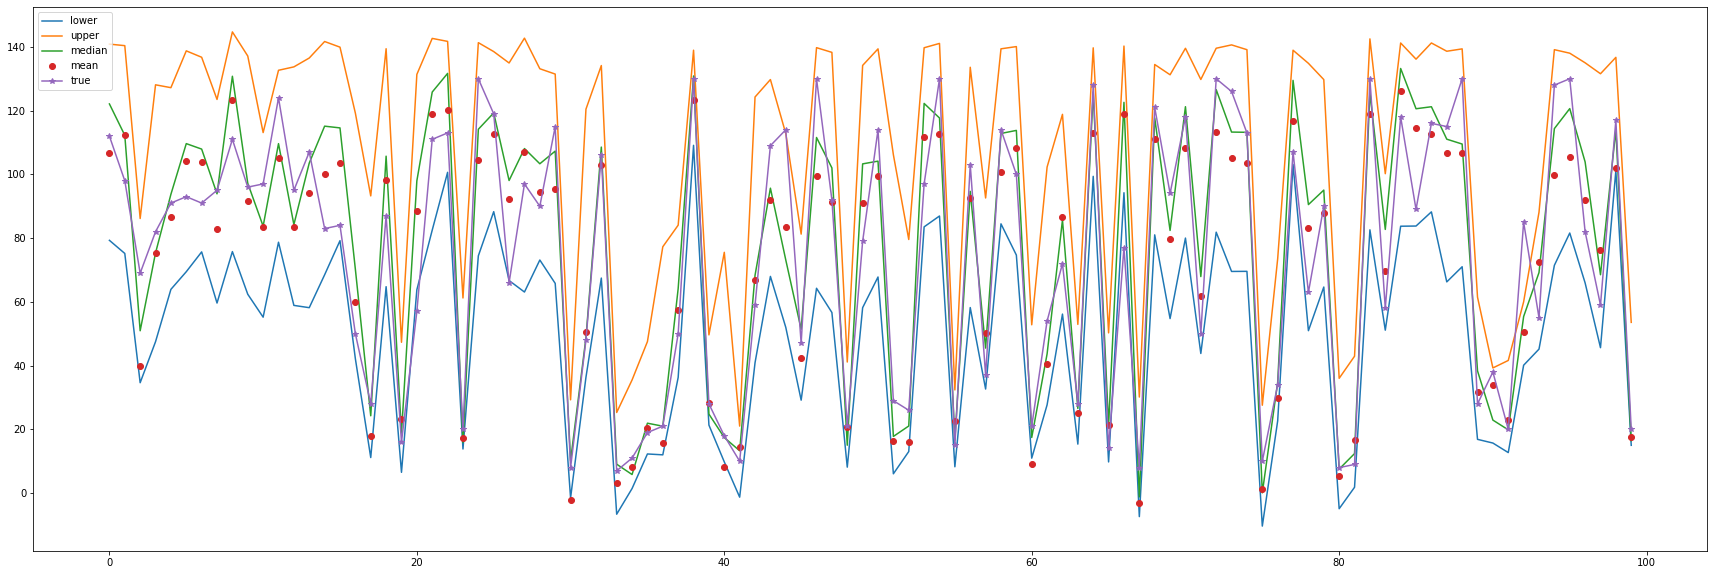

In [159]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test), label='lower')
plt.plot(model_high.predict(X_test), label='upper')
plt.plot(model_median.predict(X_test), label='median')
plt.plot(model_mean.predict(X_test),'o', label='mean')
plt.plot(y_test, '*-', label='true')
plt.legend(loc="upper left")

In [160]:
scores = np.maximum(model_low.predict(X_calib) - y_calib, y_calib - model_high.predict(X_calib))
n = X_calib.shape[0]
q = np.quantile(scores, np.ceil((n+1)*(1-alpha))/n)

56/56 [==============================] - 1s 9ms/step


In [161]:
q

-2.6994846778362147

4/4 [==============================] - 0s 8ms/step


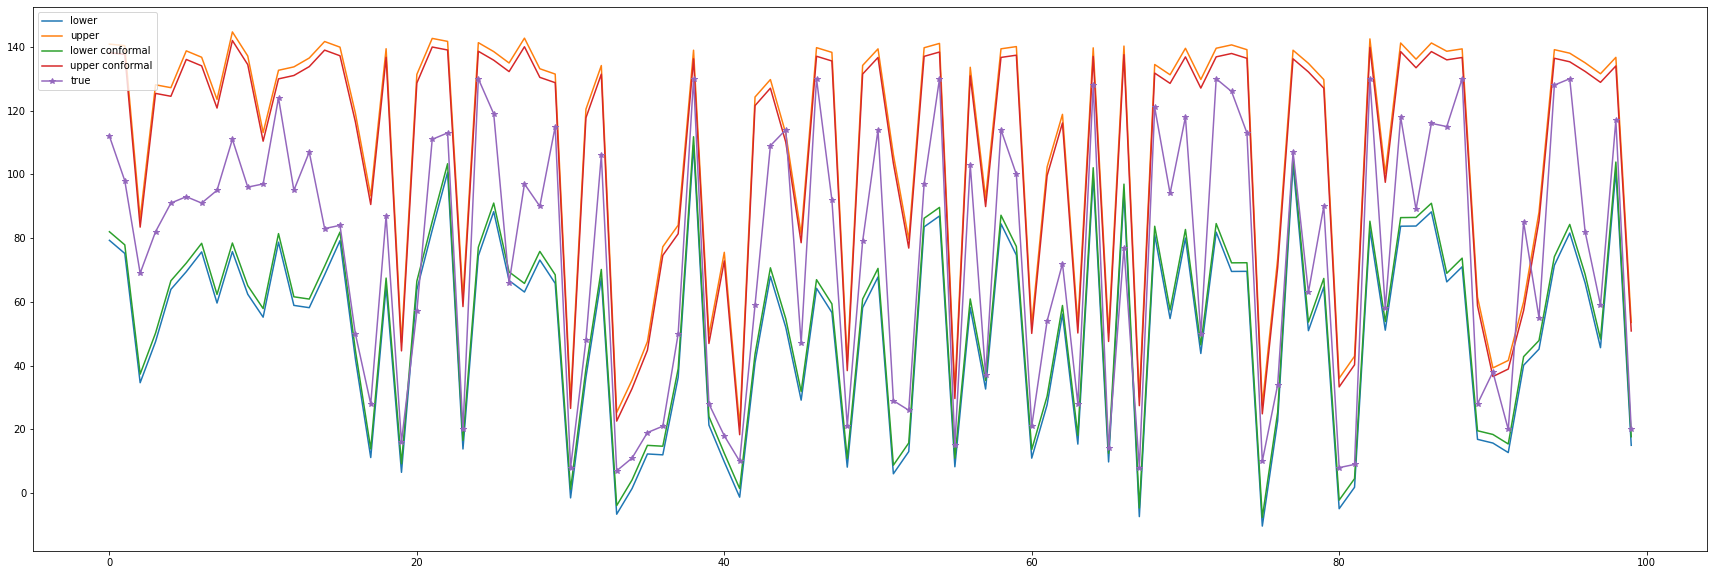

In [162]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test), label='lower')
plt.plot(model_high.predict(X_test), label='upper')
plt.plot(model_low.predict(X_test) - q, label='lower conformal')
plt.plot(model_high.predict(X_test) + q, label='upper conformal')
plt.plot(y_test, '*-', label='true')
plt.legend(loc="upper left")

# What is the coverage? 


In [163]:
sum((y_test >= (model_low.predict(X_test) -q)) & (y_test <= (model_high.predict(X_test) +q)))

4/4 [==============================] - 0s 7ms/step


array([94])

In [164]:
sum((y_test >= (model_low.predict(X_test))) & (y_test <= (model_high.predict(X_test))))

4/4 [==============================] - 0s 6ms/step


array([95])

In [165]:
sum(y_test >= (model_low.predict(X_test) -q))

4/4 [==============================] - 0s 8ms/step


array([97])

In [166]:
sum(y_test >= (model_low.predict(X_test)))

4/4 [==============================] - 0s 11ms/step


array([97])

# control the left and right tails independently

In [167]:
scores_low = model_low.predict(X_calib) - y_calib
scores_high = y_calib - model_high.predict(X_calib) 
alpha_low = alpha/10
alpha_high = alpha - alpha_low
n = X_calib.shape[0]
q_low = np.quantile(scores, np.ceil((n+1)*(1-alpha_low))/n)
q_high = np.quantile(scores, np.ceil((n+1)*(1-alpha_high))/n)
print(f"lower quantile is {q_low} and high quantile is {q_high}")

56/56 [==============================] - 0s 8ms/step
lower quantile is 7.6394216973994125 and high quantile is -2.181083343746697


4/4 [==============================] - 0s 10ms/step


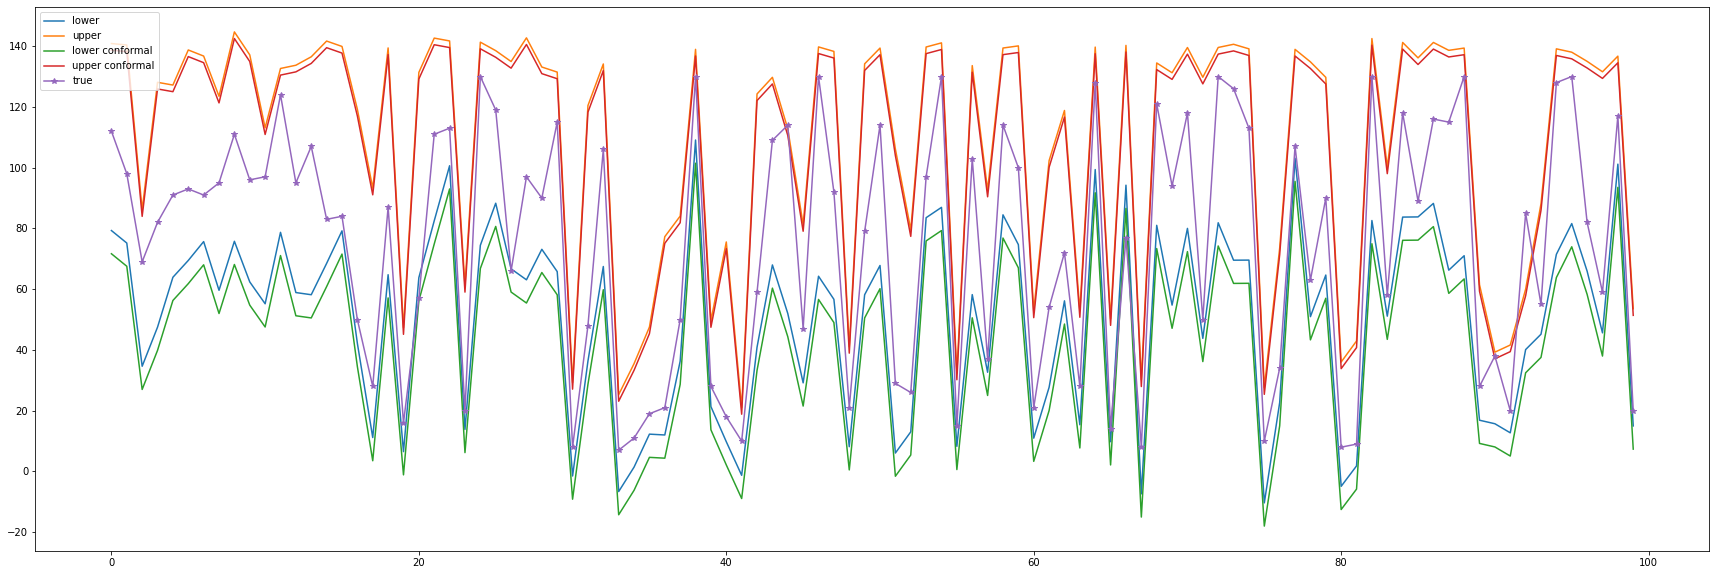

In [168]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test), label='lower')
plt.plot(model_high.predict(X_test), label='upper')
plt.plot(model_low.predict(X_test) - q_low, label='lower conformal')
plt.plot(model_high.predict(X_test) + q_high, label='upper conformal')
plt.plot(y_test, '*-', label='true')
plt.legend(loc="upper left")

In [169]:
sum((y_test >= (model_low.predict(X_test) - q_low)) & (y_test <= (model_high.predict(X_test) + q_high)))

4/4 [==============================] - 0s 7ms/step


array([96])

In [170]:
sum(y_test >= (model_low.predict(X_test) -q_low))

4/4 [==============================] - 0s 8ms/step


array([99])

# What is the average prediction interval length?

In [171]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test))

4/4 [==============================] - 0s 8ms/step


57.706196

In [172]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test) + 2*q)

4/4 [==============================] - 0s 7ms/step


52.30723

In [173]:
np.mean(model_high.predict(X_test) + q_high - model_low.predict(X_test) + q_low)

4/4 [==============================] - 0s 7ms/step


63.164536

# How is the histogram of the prediction set size?
A wider spread is generally desirable, since it means that the
procedure is effectively distinguishing between easy and hard inputs.
 

4/4 [==============================] - 0s 10ms/step


(array([ 5.,  6.,  8., 12., 20., 21., 22.,  2.,  3.,  1.]),
 array([ 21.930685,  29.841705,  37.752728,  45.663746,  53.574768,
         61.48579 ,  69.39681 ,  77.30783 ,  85.21885 ,  93.129875,
        101.04089 ], dtype=float32),
 <BarContainer object of 10 artists>)

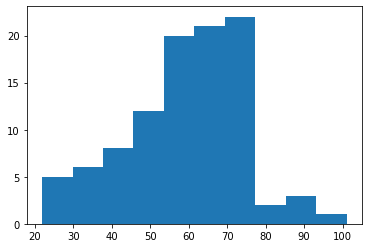

In [143]:
plt.hist(model_high.predict(X_test) - model_low.predict(X_test))

# Is there a relation between the true labels(RUL) and the interval lengths? 
Can we see that the higher the RUL, the higher the length? 

4/4 [==============================] - 0s 9ms/step


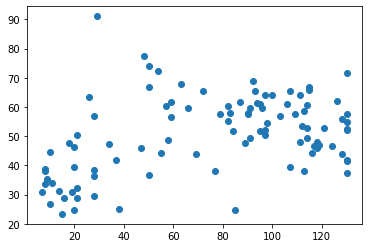

In [123]:
plt.scatter(y_test, model_high.predict(X_test) - model_low.predict(X_test))

# How about the available data points? 
Is it the case that the more data we have the smaller the prediction intervals? 

4/4 [==============================] - 0s 9ms/step


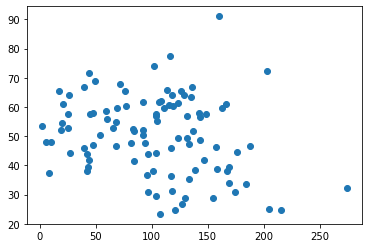

In [124]:
leng = []
for i in range(len(test[0])):
    leng.append(test[0][i].shape[0])

plt.scatter(leng, model_high.predict(X_test) - model_low.predict(X_test))

# FD002

In [29]:
dataset = data.get_dataset("CMAPSS2")
window_size = 20
calib = 50
data_num = 259


scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)

test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=window_size-1)
test = pre.dataframe_to_supervised(test, n_in=window_size-1)


X = np.vstack(train[0][:calib])
y = np.vstack(train[1][:calib])

X_calib = np.vstack(train[0][calib:])
y_calib = np.vstack(train[1][calib:])

X_test = []
y_test = []
for i in range(data_num):
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])

X_test = np.array(X_test)
y_test = np.array(y_test)
# model = net.create_model(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0)
# model.summary()


# model.compile(optimizer=Adam(learning_rate=1e-1), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

# model.fit(x=X, y=y, batch_size = 512, epochs = 50)


def quantile_loss(q,y_true,y_pred):
    """
    q -- quantile level
    y_true -- true values
    y_pred -- predicted values
    """
    diff = (y_true - y_pred)
    mask = y_true >= y_pred
    mask_ = y_true < y_pred
    loss = (q * K.sum(tf.boolean_mask(diff, mask), axis=-1) - (1 - q) * K.sum(tf.boolean_mask(diff, mask_), axis=-1))
    return loss

model_low = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_high = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model_mean = net.simple_cnn(window_size=window_size, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)

model_low.compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(0.05,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_high .compile(optimizer=Adam(learning_rate=1e-3), loss=lambda y_true,y_pred: quantile_loss(0.95,y_true,y_pred), metrics=[RootMeanSquaredError()])
model_mean.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

model_low.fit(x=X, y=y, batch_size = 512, epochs = 50)
model_high.fit(x=X, y=y, batch_size = 512, epochs = 50)
model_mean.fit(x=X, y=y, batch_size = 512, epochs = 50)


Epoch 1/50
18/18 [==============================] - 3s 123ms/step - loss: 2060.3813 - root_mean_squared_error: 89.6861
Epoch 2/50
18/18 [==============================] - 2s 131ms/step - loss: 2007.1660 - root_mean_squared_error: 85.3930
Epoch 3/50
18/18 [==============================] - 2s 128ms/step - loss: 1986.5383 - root_mean_squared_error: 83.6994
Epoch 4/50
18/18 [==============================] - 2s 118ms/step - loss: 1957.0070 - root_mean_squared_error: 82.8948
Epoch 5/50
18/18 [==============================] - 2s 102ms/step - loss: 1937.3744 - root_mean_squared_error: 81.5947
Epoch 6/50
18/18 [==============================] - 2s 110ms/step - loss: 1908.3921 - root_mean_squared_error: 81.3622
Epoch 7/50
18/18 [==============================] - 2s 127ms/step - loss: 1866.9215 - root_mean_squared_error: 79.4107
Epoch 8/50
18/18 [==============================] - 2s 130ms/step - loss: 1832.5569 - root_mean_squared_error: 77.2628
Epoch 9/50
18/18 [==============================

9/9 [==============================] - 0s 4ms/step


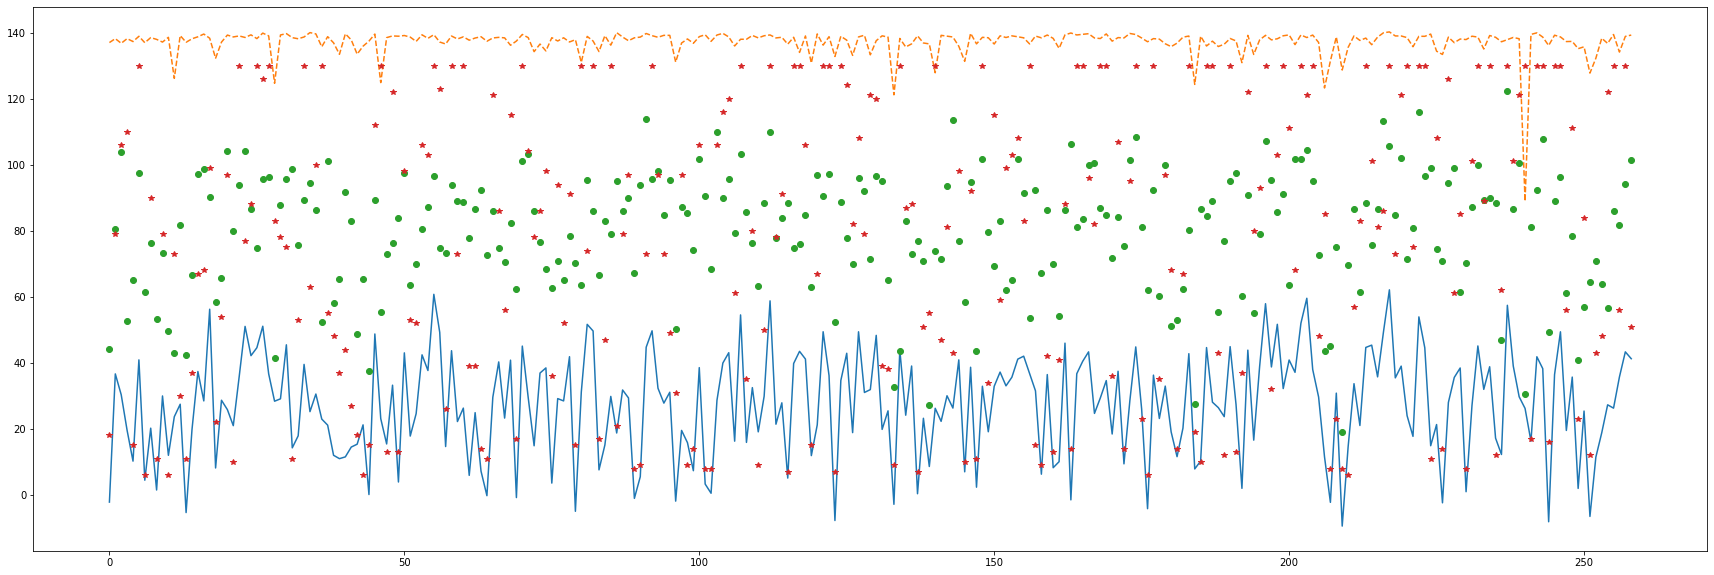

In [30]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test),'-')
plt.plot(model_high.predict(X_test),'--')
plt.plot(model_mean.predict(X_test),'o')
plt.plot(y_test, '*')

In [31]:
scores = np.maximum(model_low.predict(X_calib) - y_calib, y_calib - model_high.predict(X_calib))
n = calib
q = np.quantile(scores, np.ceil((n+1)*(0.9))/n)
q

1240/1240 [==============================] - 8s 7ms/step


-3.82183040618896

9/9 [==============================] - 0s 8ms/step


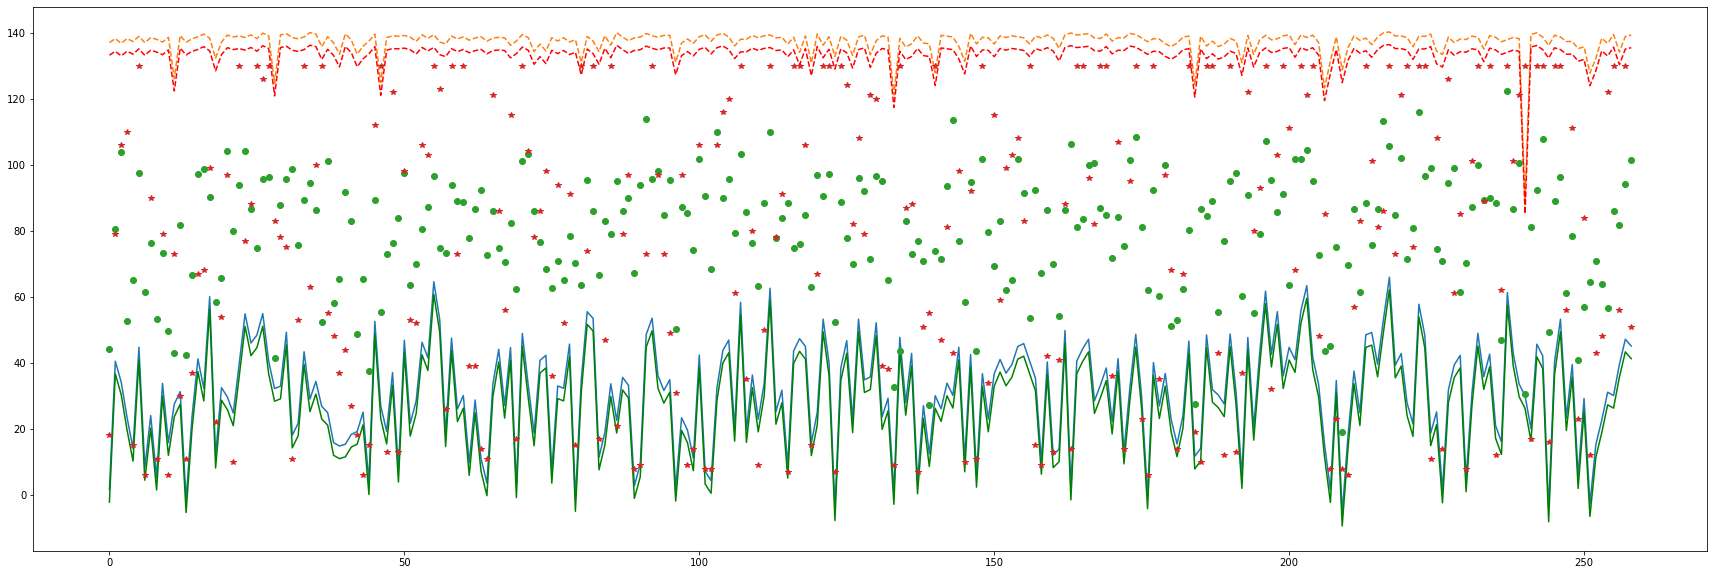

In [32]:
plt.figure(figsize=(30, 10))
plt.plot(model_low.predict(X_test)-q,'-')
plt.plot(model_low.predict(X_test),'g-')
plt.plot(model_high.predict(X_test),'--')
plt.plot(model_high.predict(X_test)+q,'r--')
plt.plot(model_mean.predict(X_test),'o')
plt.plot(y_test, '*')

In [33]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test))

9/9 [==============================] - 0s 6ms/step


109.88589

In [34]:
np.mean(model_high.predict(X_test) - model_low.predict(X_test) + 2*q)

9/9 [==============================] - 0s 6ms/step


102.24223

In [19]:
np.maximum(a,b)

array([[-12.302734 ],
       [-12.186874 ],
       [-12.1254425],
       ...,
       [-21.353964 ],
       [-20.217932 ],
       [-20.41558  ]], dtype=float32)

In [54]:
import src.data.datasets as data


dataset = data.get_dataset("CMAPSS2")

In [55]:
dataset["train"]

,id,time,os1,os2,os3,sm01,sm02,sm03,sm04,sm05,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,4
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,3
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,2
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,1


In [56]:
dataset["test"]

,id,time,os1,os2,os3,sm01,sm02,sm03,sm04,sm05,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,259,119,35.0015,0.8403,100.0,449.44,555.56,1366.01,1129.47,5.48,...,2388.39,8088.36,9.3215,0.02,334,2223,100.00,14.94,8.9065,55
33987,259,120,42.0066,0.8405,100.0,445.00,549.42,1351.13,1123.86,3.91,...,2388.31,8108.48,9.3542,0.02,332,2212,100.00,10.57,6.4075,54
33988,259,121,42.0061,0.8400,100.0,445.00,549.65,1349.14,1118.91,3.91,...,2388.34,8098.77,9.3836,0.02,331,2212,100.00,10.57,6.4805,53
33989,259,122,0.0024,0.0003,100.0,518.67,642.58,1589.61,1408.16,14.62,...,2388.00,8161.85,8.4279,0.03,393,2388,100.00,39.08,23.3589,52


In [73]:
from sklearn.preprocessing import MinMaxScaler
import src.data.preprocessor as pre


scaler = MinMaxScaler(feature_range=(-1, 1))
train = pre.apply_scaling_fn(scaler.fit_transform, dataset["train"])
test = pre.apply_scaling_fn(scaler.transform, dataset["test"])
removable_cols = ["sm01", "sm05", "sm06", "sm10", "sm16", "sm18", "sm19"]
cmapss_op_list = ["time", "os1", "os2", "os3"]
removable_cols += cmapss_op_list
train = train.drop(removable_cols, axis=1)
test = test.drop(removable_cols, axis=1)
train = pre.dataframe_to_supervised(train, n_in=29)
test = pre.dataframe_to_supervised(test, n_in=29)




In [72]:
test[0][28].shape

(72, 30, 14, 1)

In [67]:
len(test[0])

259

In [68]:
import numpy as np
X_test = []
y_test = []
for i in range(100):
    print(i)
    X_test.append(test[0][i][-1,:,:,:])
    y_test.append(test[1][i][-1,:])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


IndexError: index -1 is out of bounds for axis 0 with size 0

In [53]:
aa  = np.array(X_test)
aa.shape

(100, 30, 14, 1)

In [5]:
train[0][0].shape

(163, 30, 14, 1)

In [6]:
import numpy as np

X = np.vstack(train[0])

In [7]:
X.shape

(17731, 30, 14, 1)

In [74]:
y = np.vstack(train[1][:50])
y.shape

(8666, 1)

In [75]:
y = np.vstack(train[1][50:])
y.shape

(37553, 1)

In [78]:
y = np.vstack(train[1])
print(37553 + 8666)
y.shape

46219


(46219, 1)

In [9]:
from keras.layers import Flatten, Dense, Conv2D, Input, Dropout, Conv1D
from keras import Model

def create_model(window_size, feature_dim, kernel_size, filter_num, dropout_rate):

    input_layer = Input(shape=(window_size, feature_dim, 1), )
    #conv layer 1
    out = Conv2D(filters=filter_num, kernel_size=kernel_size, padding='same', activation='tanh')(input_layer)
    #conv layer 2
    out = Conv2D(filters=filter_num, kernel_size=kernel_size, padding='same', activation='tanh')(out)
    #conv layer 3
    out = Conv2D(filters=filter_num, kernel_size=kernel_size, padding='same', activation='tanh')(out)
    #conv layer 4
    out = Conv2D(filters=filter_num, kernel_size=kernel_size, padding='same', activation='tanh')(out)
    #conv layer 5
    out = Conv2D(filters=1, kernel_size=(3, 1), padding='same', activation='tanh')(out)
    #flatten layer 
    out = Flatten()(out)
    #dropout layer 
    out = Dropout(dropout_rate)(out)
    out = Dense(1, activation="tanh")(out)
    model = Model(inputs=input_layer, outputs=out)

    return model

In [79]:
import tensorflow as tf

In [10]:
model = create_model(window_size=30, feature_dim=14, kernel_size=(10, 1), filter_num=10, dropout_rate=0.5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 14, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 14, 10)        110       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 14, 1)         31        
                                                                 
 flatten (Flatten)           (None, 420)               0     

In [11]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model.compile(optimizer=Adam(learning_rate=1e-3), loss=MeanSquaredError())

model.fit(
    x=X,
    y=y
)

: 

: 

In [20]:
import src.data.preprocessor as pre

split_dataset = pre.split_dataset(dataset)

In [21]:
split_dataset

{'name': 'CMAPSS1',
 'train':         id  time     os1     os2    os3    sm01    sm02     sm03     sm04  \
 0        1     1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
 1        1     2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
 2        1     3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
 3        1     4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
 4        1     5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   
 ...    ...   ...     ...     ...    ...     ...     ...      ...      ...   
 20626  100   196 -0.0004 -0.0003  100.0  518.67  643.49  1597.98  1428.63   
 20627  100   197 -0.0016 -0.0005  100.0  518.67  643.54  1604.50  1433.58   
 20628  100   198  0.0004  0.0000  100.0  518.67  643.42  1602.46  1428.18   
 20629  100   199 -0.0011  0.0003  100.0  518.67  643.23  1605.26  1426.53   
 20630  100   200 -0.0032 -0.0005  100.0  518.67  643.85  1600.38  1432.14   
 
         sm05  ...     sm13     s

In [22]:
split_dataset["train_splits"][0]["train"]

,id,time,os1,os2,os3,sm01,sm02,sm03,sm04,sm05,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [23]:
split_dataset["train_splits"][0]["test"]

,id,time,os1,os2,os3,sm01,sm02,sm03,sm04,sm05,...,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21,rul
1914,10,1,-0.0014,0.0004,100.0,518.67,641.92,1587.93,1392.20,14.62,...,2388.01,8137.61,8.4039,0.03,391,2388,100.0,39.04,23.5309,221
1915,10,2,0.0009,0.0005,100.0,518.67,642.22,1586.81,1392.03,14.62,...,2388.04,8142.57,8.3868,0.03,390,2388,100.0,39.05,23.3106,220
1916,10,3,0.0009,-0.0000,100.0,518.67,642.16,1581.06,1395.51,14.62,...,2387.97,8136.85,8.4422,0.03,392,2388,100.0,39.01,23.5053,219
1917,10,4,0.0010,0.0004,100.0,518.67,642.14,1590.17,1388.15,14.62,...,2388.03,8136.62,8.3928,0.03,391,2388,100.0,38.83,23.3314,218
1918,10,5,-0.0020,-0.0003,100.0,518.67,642.13,1581.09,1396.37,14.62,...,2388.01,8138.95,8.3879,0.03,392,2388,100.0,39.06,23.4651,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17147,84,263,-0.0021,0.0004,100.0,518.67,643.69,1601.97,1422.61,14.62,...,2388.21,8151.87,8.5247,0.03,395,2388,100.0,38.41,23.0407,4
17148,84,264,-0.0027,-0.0000,100.0,518.67,643.34,1599.89,1429.65,14.62,...,2388.20,8148.87,8.5464,0.03,397,2388,100.0,38.49,22.9996,3
17149,84,265,0.0026,0.0001,100.0,518.67,643.87,1598.81,1436.17,14.62,...,2388.18,8148.76,8.5113,0.03,396,2388,100.0,38.49,23.0383,2
17150,84,266,-0.0013,-0.0000,100.0,518.67,643.20,1605.59,1428.10,14.62,...,2388.20,8146.22,8.5336,0.03,395,2388,100.0,38.36,23.0022,1


In [24]:
18559 + 2072


20631

In [23]:
proc_dataset = pre.preprocess_split_dataset(split_dataset)

In [33]:
proc_dataset['train_splits'][0]['train'][0][0].shape

(192, 16)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 30, 14, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 14, 10)        110       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 14, 10)        1010      
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 14, 1)         31        
                                                                 
 flatten_2 (Flatten)         (None, 420)               0   